These days, machine learning and deep neural networks are exploding in importance. These fields are so popular that even a cave man might have heard it once. The exaggeration not withstanding, there is perhaps no necessity to justify the topic for today's blog post: exploring a machine learning algorithm by building it from scratch. Apparently, "from scratch" is now a trendy pedagogical methodology employed in many websites and resources that claim to educate their readers about machine learning. To this, I agree: by constructing algorithms from the ground up, one can glean meaningful insights about how machine learning actually works. At the same time, however, I feel ambivalent because real-life practice requires us to be knowledgable about popular libraries and modules. This is why I see today's post---building the k-nearest neighbors algorithm from scratch---as being just one side of the picture, the other side being the exploration of how to use popular libraries such as `sklearn` to implement machine learning. 

Enough of the prologue, let's jump right in. 

# Building k-Nearest Neighbors

As the name implies, the [k-nearest neighbors algorithm] works by findinng the nearest neighbors of some give data. Then, it looks at the labels of $k$ neighboring points to produce a classification prediction. Here, $k$ is a parameter that we can tweak to build the KNN model. For instance, let's say we have a binary classification problem. If we set $k$ to 10, the KNN modell will look for 10 nearest points to the data presented. If among the 10 neighbors observed, 8 of them have the label 0 and 2 of them are labeled 1, the KNN algorithm will conclude that the label of the provided data is most likely also going to be 0. As we can see, the KNN algorithm is extremely simple, but if we have enough data to feed it, it can produce some highly accurate predictions. 

There are still missing pieces to this puzzle, such as how to find the nearest neighbors, but we will explore the specifics of the algorithm on the go as we build the model from scratch. For now, just remember the big picture. Let's get into the nuts and bolts of the KNN model. Below are the dependencies we will need for this demonstration.

In [162]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")

## Euclidean Distance

One problem we need to start thinking about is how to measure distance between two data points. After all, the implementation of KNN requires that we define some metric to measure the proximity between different points, rank them in order, and sort the list to find $k$ nearest neighbors. One way to go about this is to use [Euclidean distance], which is defined as follows:

$$\begin{align*} d(p, q) &= \sqrt{(q_1 - p_1)^2 + (q_2 - p_2)^2 + \cdots (q_n - p_n)^2} \\ &= \sqrt{\sum_{i = 1}^n (q_i - p_i)^2} \end{align*}$$

It is not difficult to build an implementation of in Python. We can easily achieve this using `numpy`.

In [16]:
def distance(instance1, instance2):
    instance1, instance2 = np.array(instance1), np.array(instance2)
    return np.sqrt(sum((instance1 - instance2)**2))

Let's test the functionality of the `distance` function using some dummy dataset. This data set was borrowed from [Jason Brownlee]. 

In [40]:
dataset = [[2.7810836,2.550537003],
           [1.465489372,2.362125076],
           [3.396561688,4.400293529],
           [1.38807019,1.850220317],
           [3.06407232,3.005305973],
           [7.627531214,2.759262235],
           [5.332441248,2.088626775],
           [6.922596716,1.77106367],
           [8.675418651,-0.242068655],
           [7.673756466,3.508563011]]
label = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

In [196]:
for data in dataset:
    print(distance(dataset[0], data))

0.0
1.3290173915275787
1.9494646655653247
1.5591439385540549
0.5356280721938492
4.850940186986411
2.592833759950511
4.214227042632867
6.522409988228337
4.985585382449795


Great! As expected, the distance between a point and itself is 0, and other calculated distances also seem reasonable. 

## Neighbor Selection

The next step is to write a function that returns the $k$ nearest neighbors of a point given a data set and parameter `k`. There are many ways to implement this, but an example is shown below. First, we enumerate thorugh the data set to calculate all the distances between the given test instance and the data points in the data set. Next, we sort the list. The returned result is a list that contains the indices of the $k$ nearest neighbors the algorithm found in the data set. Note that we use the `distance` function we wrote above.

In [197]:
def get_neighbors(training_set, test_instance, k):
    distances = [(i, distance(test_instance, instance)) for i, instance in enumerate(training_set)]
    distances.sort(key=lambda x: x[1])
    return [i[0] for i in distances[:k]]

Let's see if the code works by testing it on our toy data. The task is to find 5 data points that are closest to the first row of `dataset`.

In [200]:
get_neighbors(dataset, dataset[0], k=7)

[0, 4, 1, 3, 2, 6, 7]

As expected, the returned list contains the indices of the data points in `dataset` that are closest to `dataset[0]`. We can confirm this by looking at the results of the distance calculation we obtained when testing the `distance` function. Note that the indices are in order; that is, indice 0 corresponds to the closet neighbor---it is in fact that data point itself---and index 2 refers to the farthest neighbor among the `k=7` selections.

## Prediction Generation

Say we have successfully obtained the list of $k$ nearest neighbors. Now what? Well, it's time to look up the labels of these neighboring data points to see which class is the most prevalent. The KNN model will then conclude that the most prevalent class label is the one that which the data point belongs to. Because this function has to perform more tasks than the functions we wrote earlier, the example code is slightly longer, but here it goes:

In [96]:
def make_prediction(neighbor_index, label):
    label = np.array(label)
    neighbor_label = label[neighbor_index]
    prediction = {}
    for x in neighbor_label:
        if x in prediction:
            prediction[x] += 1
        else:
            prediction[x] = 1
    total = sum(prediction.values())
    probability_prediction = {k: v/total for k, v in prediction.items()}
    return probability_prediction

Basically, the `make_prediction` function counts the number of labels of each class and stores the results in a dictionary. Then, it normalizes the values of the dictionary by dividing its values by the total number of data points seen. Although this process is not necessary, it helps us interpret the results in terms of percentages. For example, the example below tells us that approximately 71 percent of the neighbors of `dataset[0]` are labeled 0; 28 percent are labeled 1.

In [201]:
make_prediction([0, 4, 1, 3, 2, 6, 7], label)

{0: 0.7142857142857143, 1: 0.2857142857142857}

Now we have all the building blocks we need. We can stop here, but let's nicely wrap all the functions we have build into a single function that we can use to train and test data. In retrospect, we could have built a class instead, but this implementation also works fine, so let's stick to it for now.

In [206]:
def knn_classifier(training_set, label, test_set, k):
    result = []
    for instance in test_set:
        neighbor_index = get_neighbors(training_set, instance, k)
        prediction = make_prediction(neighbor_index, label)
        result.append(max(prediction, key=prediction.get))
    return np.array(result)

Let's see what the `knn_classifer` tells us about `dataset[0]`. Here, we pass on `dataset[1:]` onto the `training_set` argument because we want to prevent the algorithm from making a prediction based on a data set that contains the data itself; that would defeat the purpose of making a prediction. Let's see how the model performs.

In [209]:
knn_classifier(dataset[1:], label, [dataset[0]], 3)

array([0])

The KNN model rightly predicts that `dataset[0]` is labeled 0. Great! But we have only been testing our model on a rather dumb data set. Let's see whether the model works with larger, closer-to-real-life data sets.

# Testing the Model

The [iris data set] from the UCI machine learning repository is perhaps one of the best known data sets in the field of machine learning. Created by R. A. Fisher, the data set contains 3 classes of 50 instances each, totaling to 150 independent observations of iris plants, specifically Iris Setosa, Iris Versicolour, and Iris Virginica. The feature columns include sepal length, sepal width, petal length, and petal width. 

Let's begin by first loading the data set from the `sklearn` library.

In [142]:
from sklearn import datasets

iris = datasets.load_iris()
iris_data = iris.data
iris_labels = iris.target

One preliminary step we might want to take is shuffling the data set and dividing it into a training set and a testing set. As the name implies, a testing set is a set of data we use to test the accuracy of our classification algorithm. A training set, on the other hand, is a data set the KNN model is going to use to make predictions, *i.e.* it is the data set from which the algorithm will try to find close neighbors. There is a special function already in the `sklearn` library that does all the shuffling and the splitting for us, but in light of the "from scratch" spirit of this post, let's try to write up the function ourselves.

In [141]:
def my_train_test_split(X, y, test_size, random_state):
    data_num = len(y)
    test_num = int(test_size * data_num)
    np.random.seed(random_state)
    index = np.random.permutation(data_num)
    X_train = X[index[:-test_num]]
    X_test = X[index[-test_num:]]
    y_train = y[index[:-test_num]]
    y_test = y[index[-test_num:]]
    return X_train, X_test, y_train, y_test

Great! We can now use this function to split the iris data set we have imported by using the following command.

In [143]:
X_train, X_test, y_train, y_test = my_train_test_split(iris_data, iris_labels, 0.2, 42)

Let's verify that the splitting has successfully been performed by checking the dimensions of the testing set.

In [211]:
X_test.shape

(30, 4)

As we expect, the testing set is a 30-by-4 matrix. In other words, it contains 4 feature columns---the width and length of sepals and petals, as mentioned earlier---and 30 observation of iris plants. We can now use the KNN model we have built to make predictions about these thirty samples. The choice of parameter `k` as 10 was arbitrary.

In [147]:
y_pred = knn_classifier(X_train, y_train, X_test, 10)
y_pred

array([1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 2, 0, 2, 0, 1, 2, 2, 1, 2, 1, 1,
       2, 2, 0, 1, 1, 0, 1, 2])

That was very simple. The returned numpy array contains the class labels for each of the thirty observations in the `X_test` matrix. In other words, the first test data was predicted to belong to class 1; second data, class 0, third data, class 1, and so on. Let's compare this predicted result with the actual labels.

In [137]:
y_test

array([1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 2, 0, 2, 0, 1, 2, 2, 1, 2, 1, 1,
       2, 2, 0, 1, 2, 0, 1, 2])

For the most part, it seems like our predicted result is quite similar to the actual labels. But there are some samples that our KNN algorithm missed, such as the 27th data point: although its actual label is 2, our model predicted it to be 1. We can mathematically calculate the accuracy of our model by using the following function. The job of this function is quite simple: it goes through the two lists, element by element, and checks if the two values are identical. See the implementation below.

In [149]:
def accuracy_score(y_true, y_pred):
    count = 0
    for true, pred in zip(y_true, y_pred):
        if true == pred:
            count += 1
    return count/len(y_true)

The accuracy of our prediction turns out to be about 97 percent.

In [150]:
accuracy_score(y_pred, y_test)

0.9666666666666667

But can we do better? Recall that we arbitrarily chose $k$ to be 10 when we initialized the KNN algorithm. Would accuracy increase if we set the parameter to another number? Let's try to answer this question by generating a list of accuracy scores for each value of $k$ ranging from 1 to 100. We can achieve this by building a function as shown below.

In [169]:
def tune_parameter(X_train, y_train, X_test, y_test, k_num):
    accuracy = []
    y_test = y_test
    for i in range(1, k_num):
        y_pred = knn_classifier(X_train, y_train, X_test, i)
        accuracy.append(accuracy_score(y_test, y_pred))
    return np.array(accuracy)

Passing 100 to the `k_num` argument results in a list of accuracy scores.

In [212]:
accuracy = tune_parameter(X_train, y_train, X_test, y_test, 100)
accuracy

array([0.96666667, 0.96666667, 0.96666667, 0.96666667, 0.96666667,
       0.96666667, 0.96666667, 0.96666667, 0.96666667, 0.96666667,
       0.96666667, 0.96666667, 0.96666667, 0.96666667, 0.96666667,
       0.96666667, 0.96666667, 0.96666667, 0.96666667, 0.96666667,
       0.96666667, 0.96666667, 0.93333333, 0.96666667, 0.93333333,
       0.93333333, 0.9       , 0.96666667, 0.96666667, 0.96666667,
       0.96666667, 0.96666667, 0.96666667, 0.96666667, 0.93333333,
       0.93333333, 0.93333333, 0.93333333, 0.93333333, 0.93333333,
       0.9       , 0.93333333, 0.93333333, 0.93333333, 0.9       ,
       0.9       , 0.9       , 0.9       , 0.9       , 0.9       ,
       0.9       , 0.9       , 0.9       , 0.9       , 0.9       ,
       0.9       , 0.9       , 0.9       , 0.9       , 0.9       ,
       0.86666667, 0.86666667, 0.86666667, 0.86666667, 0.86666667,
       0.86666667, 0.86666667, 0.9       , 0.86666667, 0.9       ,
       0.9       , 0.9       , 0.86666667, 0.86666667, 0.86666

We can go through this list and try to see for which value of $k$ accuracy is maximized. But this is a rather tedious job, and things would get quickly out of control if we were to deal with much larger data sets where the value of $k$ can be set to much larger numbers. Instead, let's create a visualization to see how accuracy changes with respect to $k$.

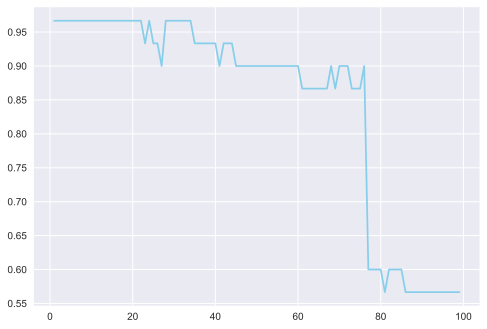

In [213]:
x = np.arange(1, 100)
y = accuracy

plt.plot(x, y, color="skyblue")
plt.show()

The plot shows that accuracy is maximized for many values of $k$, not just 1. Also, we can learn that accuracy does not go beyond the 97 percent we saw earlier, which is a bit of sad news. An interesting insight we can glean, however, is that accuracy seems to drop past some certain thresholds, most notably around 80. One reasonable explanation might be that the model is looking at too many neighbors that it cannot produce a reliable estimate. At any rate, this visualization shows that hyperparameter tuning is an important job of a machine learning engineer---even if the model is great, if the wrong $k$ value is used, the model will only demonstrate lackluster performance.

# Conclusion

This was perhaps the first post where we dealt with a machine learning algorithm. ML is sometimes treated as a black box, where some magic beneath the hood produces desirable results. However, I find exploring these mechanisms a lot more interesting than simply using pre-existing modules and libraries, as important as they may be. Hopefully, this post gave you some idea of how the KNN model works. 

I plan to post more on machine learning algorithms in the future, because I find the idea of building models from scratch to be interesting and valuable. However, as stated earlier, other posts will deal with libraries to help demonstrate how machine learning models are used in practice; after all, most practitioners don't build the model themselves every time they embark on a project. The bottom line is that we find a sweet spot and become skilled at both. 

Catch you up in the next one. Happy new year!

[Euclidean distance]: https://en.wikipedia.org/wiki/Euclidean_distance
[Jason Brownlee]: https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/
[iris data set]: https://archive.ics.uci.edu/ml/datasets/iris
[k-nearest neighbors algorithm]: https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm